Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009',
       'SUB_2006', 'geometry', 'roc_auc'],
      dtype='object')


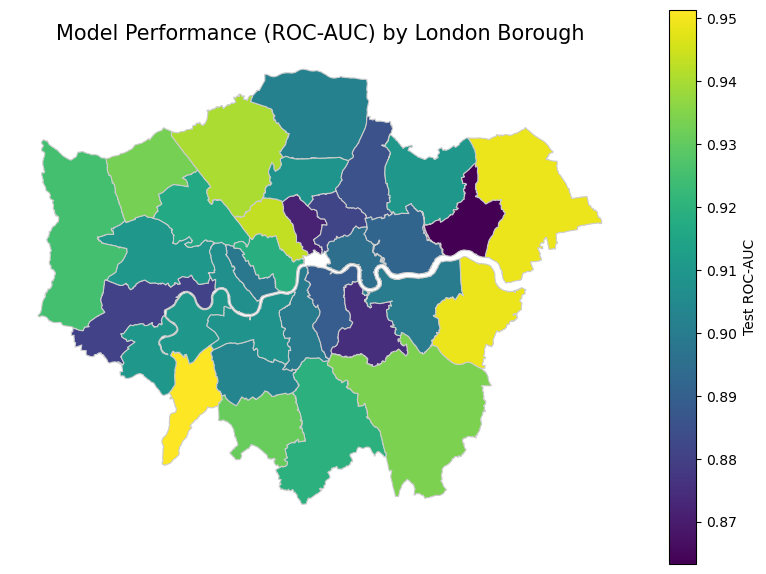

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

df_auc = pd.read_csv("auc_by_borough.csv")

df_auc.columns = df_auc.columns.str.strip().str.lower()
df_auc = df_auc.rename(columns={"borough": "NAME", "auc": "auc"})

gdf = gpd.read_file("statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")

gdf["NAME"] = gdf["NAME"].str.strip().str.lower()
df_auc["NAME"] = df_auc["NAME"].str.strip().str.lower()


gdf_merged = gdf.merge(df_auc, on="NAME", how="left")
print(gdf_merged.columns)


gdf_merged = gdf_merged.rename(columns={"roc_auc": "auc"})

fig, ax = plt.subplots(figsize=(10, 12))
gdf_merged.plot(column="auc", cmap="viridis", linewidth=0.8, edgecolor="0.8",
                legend=True, ax=ax, legend_kwds={'label': "Test ROC-AUC", 'shrink': 0.6})
ax.set_title("Model Performance (ROC-AUC) by London Borough", fontsize=15)
ax.axis("off")

plt.savefig("auc_by_borough_map.png", bbox_inches="tight", dpi=300)
plt.show()



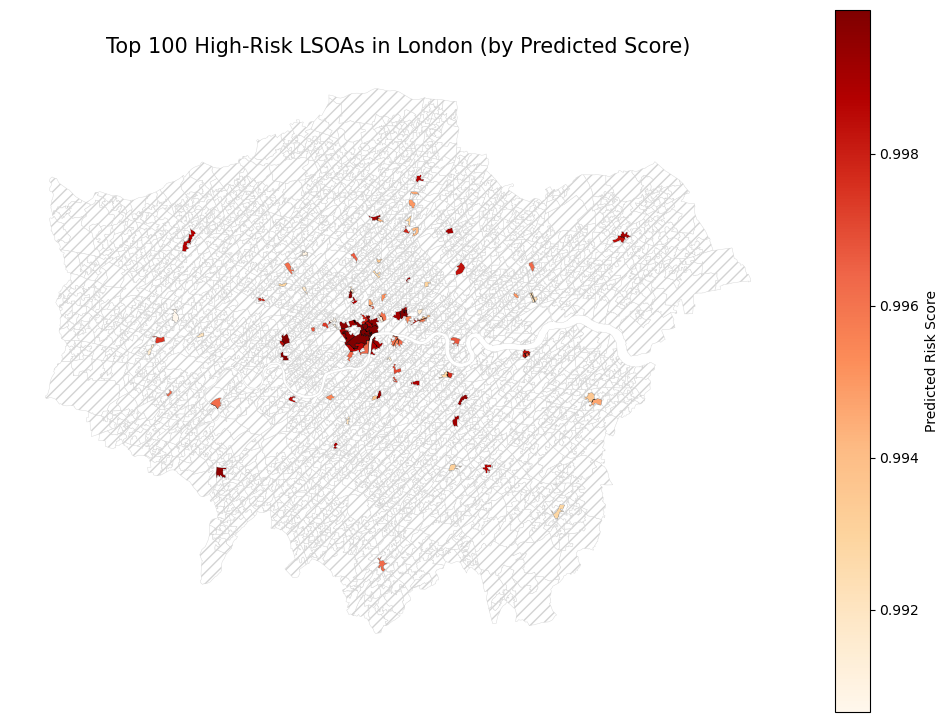

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

top100 = pd.read_csv("top100_high_risk_latest.csv", dtype={"LSOA_Code": str})
shp_path = "statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp"
gdf = gpd.read_file(shp_path)

code_col = next((c for c in gdf.columns if c.upper() == "LSOA11CD"), None)
if code_col is None:
    code_col = [c for c in gdf.columns if "LSOA" in c.upper() and "CD" in c.upper()][0]
gdf = gdf[[code_col, "geometry"]].rename(columns={code_col: "LSOA_Code"})

gdf_merged = gdf.merge(top100[["LSOA_Code", "score"]], on="LSOA_Code", how="left")

fig, ax = plt.subplots(figsize=(10, 12))
gdf_merged.plot(
    column="score",
    cmap="OrRd",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
    missing_kwds={
        "color": "white",
        "edgecolor": "lightgrey",
        "hatch": "///",
        "label": "Not in Top 100"
    },
    ax=ax,
    legend_kwds={'label': "Predicted Risk Score", 'shrink': 0.6}
)
ax.set_title("Top 100 High-Risk LSOAs in London (by Predicted Score)", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.savefig("top100_lsoa_risk_map.png", dpi=300)
plt.show()

In [3]:
def classify_areas_by_risk_patterns():
    # Load test prediction results with 'date' parsed as datetime
    pred_test = pd.read_csv("predictions_test.csv", parse_dates=["date"])
    
    # Analyze risk patterns for each LSOA
    risk_profiles = []
    for lsoa_code in pred_test["LSOA_Code"].unique():
        lsoa_data = pred_test[pred_test["LSOA_Code"] == lsoa_code]
        
        # Only analyze if there are at least 30 months of data
        if len(lsoa_data) >= 30:
            mean_score = lsoa_data["score"].mean()
            std_score = lsoa_data["score"].std()
            high_risk_pct = (lsoa_data["score"] >= 0.37).mean()  # Proportion of high-risk months
            volatility = std_score / mean_score if mean_score > 0 else 0
            
            # Classify LSOAs based on risk characteristics
            if mean_score < 0.1:
                category = "Consistently Low Risk"
            elif mean_score > 0.5:
                category = "Persistently High Risk"
            elif volatility > 1.5 and high_risk_pct > 0.2:
                category = "Highly Volatile"
            else:
                category = "Moderate Risk"
            
            risk_profiles.append({
                "LSOA_Code": lsoa_code,
                "Mean_Score": mean_score,
                "Std_Score": std_score,
                "High_Risk_Pct": high_risk_pct,
                "Volatility": volatility,
                "Category": category
            })
    
    return pd.DataFrame(risk_profiles)

# Run the function to generate the risk profile table
risk_df = classify_areas_by_risk_patterns()

# Print out the number of LSOAs in each risk category
print("Risk category distribution:")
print(risk_df["Category"].value_counts())

# Select 1 representative case for each category
case_studies = {}
for category in risk_df["Category"].unique():
    category_data = risk_df[risk_df["Category"] == category].sort_values("Mean_Score")
    if len(category_data) > 0:
        # Choose the most representative case: the one at the median position
        representative = category_data.iloc[len(category_data)//2]
        case_studies[category] = representative["LSOA_Code"]

# Print selected case studies with summary statistics
print("\nSelected case studies:")
for category, lsoa_code in case_studies.items():
    info = risk_df[risk_df["LSOA_Code"] == lsoa_code].iloc[0]
    print(f"{category}: {lsoa_code} (Mean Score = {info['Mean_Score']:.3f}, High-Risk Rate = {info['High_Risk_Pct']:.1%})")


Risk category distribution:
Category
Moderate Risk             1915
Consistently Low Risk     1787
Persistently High Risk     951
Name: count, dtype: int64

Selected case studies:
Consistently Low Risk: E01001217 (Mean Score = 0.042, High-Risk Rate = 0.0%)
Persistently High Risk: E01001164 (Mean Score = 0.783, High-Risk Rate = 100.0%)
Moderate Risk: E01000312 (Mean Score = 0.213, High-Risk Rate = 13.8%)


In [ ]:
case_studies = {
    "Consistently Low Risk": "E01001217",
    "Persistently High Risk": "E01001164", 
    "Moderate Risk": "E01000312"
}

def get_case_study_info(case_studies):
    static = pd.read_csv("feature_static_london.csv")
    pred_test = pd.read_csv("predictions_test.csv", parse_dates=["date"])
    imd_data = pd.read_csv("IMD2019.csv", dtype=str)
    
    borough_lookup = imd_data.rename(columns={
        "LSOA code (2011)": "LSOA_Code",
        "Local Authority District name (2019)": "Borough"
    })[["LSOA_Code", "Borough"]]
    
    case_info = []
    for label, lsoa_code in case_studies.items():
        borough_info = borough_lookup[borough_lookup["LSOA_Code"] == lsoa_code]
        static_info = static[static["LSOA_Code"] == lsoa_code]
        pred_info = pred_test[pred_test["LSOA_Code"] == lsoa_code]
        
        info = {
            "Category": label,
            "LSOA_Code": lsoa_code,
            "Borough": borough_info["Borough"].iloc[0] if not borough_info.empty else "Unknown",
            "Mean_Risk_Score": pred_info["score"].mean() if not pred_info.empty else 0,
            "High_Risk_Percentage": (pred_info["score"] >= 0.37).mean() * 100 if not pred_info.empty else 0,
            "Population_Density": static_info["pop_density"].iloc[0] if not static_info.empty and "pop_density" in static_info.columns else "N/A",
            "Income_Deprivation": static_info["dep_income"].iloc[0] if not static_info.empty and "dep_income" in static_info.columns else "N/A"
        }
        case_info.append(info)
    
    return pd.DataFrame(case_info)

case_info_df = get_case_study_info(case_studies)
print(case_info_df.round(3))

In [ ]:
def plot_detailed_risk_comparison(pred_test, case_studies, save_path="detailed_case_study_analysis.png"):
    fig = plt.figure(figsize=(16, 12))

    gs = fig.add_gridspec(3, 3, height_ratios=[1, 1, 1], width_ratios=[2, 1, 1])
    
    colors = ['#2E8B57', '#DC143C', '#4682B4']
    
    for i, (label, lsoa_code) in enumerate(case_studies.items()):
        ax_time = fig.add_subplot(gs[i, 0])
        
        lsoa_data = pred_test[pred_test["LSOA_Code"] == lsoa_code].sort_values("date")
        
        if not lsoa_data.empty:
            ax_time.plot(lsoa_data["date"], lsoa_data["score"], 
                        linewidth=2.5, color=colors[i], alpha=0.8)

            ax_time.axhline(y=0.37, color='red', linestyle='--', alpha=0.7, linewidth=1)
            ax_time.fill_between(lsoa_data["date"], lsoa_data["score"], 0.37, 
                               where=(lsoa_data["score"] >= 0.37), alpha=0.3, 
                               color='red', label='High-risk periods')

            mean_score = lsoa_data["score"].mean()
            std_score = lsoa_data["score"].std()
            high_risk_pct = (lsoa_data["score"] >= 0.37).mean() * 100
            
            ax_time.set_title(f'{label}\nLSOA: {lsoa_code}', fontsize=12, fontweight='bold')
            ax_time.set_ylabel("Risk Score", fontsize=10)
            ax_time.grid(True, alpha=0.3)
            
            stats_text = f'Mean: {mean_score:.3f}\nStd: {std_score:.3f}\nHigh-Risk: {high_risk_pct:.1f}%'
            ax_time.text(0.02, 0.98, stats_text, transform=ax_time.transAxes, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            if i == 2:
                ax_time.set_xlabel("Date", fontsize=10)
            else:
                ax_time.set_xticklabels([])

    ax_hist = fig.add_subplot(gs[:, 1])
    
    for i, (label, lsoa_code) in enumerate(case_studies.items()):
        lsoa_data = pred_test[pred_test["LSOA_Code"] == lsoa_code]
        if not lsoa_data.empty:
            ax_hist.hist(lsoa_data["score"], bins=30, alpha=0.6, 
                        label=label, color=colors[i], orientation='horizontal')
    
    ax_hist.axhline(y=0.37, color='red', linestyle='--', alpha=0.7)
    ax_hist.set_ylabel("Risk Score")
    ax_hist.set_xlabel("Frequency")
    ax_hist.set_title("Risk Score\nDistribution")
    ax_hist.legend()
    ax_hist.grid(True, alpha=0.3)

    ax_yearly = fig.add_subplot(gs[:, 2])
    
    for i, (label, lsoa_code) in enumerate(case_studies.items()):
        lsoa_data = pred_test[pred_test["LSOA_Code"] == lsoa_code]
        if not lsoa_data.empty:
            yearly_avg = lsoa_data.groupby(lsoa_data["date"].dt.year)["score"].mean()
            ax_yearly.plot(yearly_avg.index, yearly_avg.values, 
                          marker='o', linewidth=2, label=label, color=colors[i])
    
    ax_yearly.axhline(y=0.37, color='red', linestyle='--', alpha=0.7)
    ax_yearly.set_xlabel("Year")
    ax_yearly.set_ylabel("Average Risk Score")
    ax_yearly.set_title("Annual Risk\nTrends")
    ax_yearly.legend()
    ax_yearly.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_detailed_risk_comparison(pred_test, case_studies)

In [ ]:
def plot_crime_type_distribution_only(case_studies, save_path="crime_type_distribution.png"):
    crime_features = pd.read_csv("crime_rolling6m.csv", parse_dates=["date"])
    latest_date = crime_features["date"].max()
    latest_crime = crime_features[crime_features["date"] == latest_date]

    crime_cols = [c for c in latest_crime.columns if c.startswith("cnt_") and "roll6" in c]
    
    crime_labels_map = {
        'cnt_VIOLENCE_AGAINST_THE_PERSON_roll6': 'Violence',
        'cnt_THEFT_roll6': 'Theft', 
        'cnt_VEHICLE_OFFENCES_roll6': 'Vehicle Crime',
        'cnt_BURGLARY_roll6': 'Burglary',
        'cnt_ROBBERY_roll6': 'Robbery',
        'cnt_PUBLIC_ORDER_OFFENCES_roll6': 'Public Order',
        'cnt_DRUG_OFFENCES_roll6': 'Drug Offences',
        'cnt_POSSESSION_OF_WEAPONS_roll6': 'Weapons',
        'cnt_ARSON_AND_CRIMINAL_DAMAGE_roll6': 'Arson & Criminal Damage',
        'cnt_MISCELLANEOUS_CRIMES_AGAINST_SOCIETY_roll6': 'Miscellaneous Crimes'
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    colors = ['#2E8B57', '#DC143C', '#4682B4']
    
    for i, (label, lsoa_code) in enumerate(case_studies.items()):
        crime_row = latest_crime[latest_crime["LSOA_Code"] == lsoa_code]
        
        if not crime_row.empty:
            crime_data = []
            crime_labels = []
            
            for col in crime_cols:
                value = crime_row[col].iloc[0]
                if value > 0:
                    crime_data.append(value)
                    clean_label = crime_labels_map.get(col, 
                                                     col.replace("cnt_", "").replace("_roll6", "").replace("_", " ").title())
                    crime_labels.append(clean_label)
            
            if crime_data:
                total_crimes = sum(crime_data)

                wedges, texts, autotexts = axes[i].pie(crime_data, labels=crime_labels, 
                                                      autopct='%1.1f%%', startangle=90,
                                                      colors=plt.cm.Set3(np.linspace(0, 1, len(crime_data))))

                axes[i].set_title(f'{label}\nLSOA: {lsoa_code}\nTotal: {total_crimes} crimes (6 months)', 
                                 fontsize=12, fontweight='bold', pad=20)

                for autotext in autotexts:
                    autotext.set_color('white')
                    autotext.set_fontsize(10)
                    autotext.set_fontweight('bold')

                for text in texts:
                    text.set_fontsize(9)
            else:
                axes[i].text(0.5, 0.5, "No crime data", ha='center', va='center', 
                           transform=axes[i].transAxes, fontsize=14)
                axes[i].set_title(f'{label}\nLSOA: {lsoa_code}\nNo data', 
                                 fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_crime_type_distribution_only(case_studies)